# Introduction and Motivation

I have always been passionate about Lego, ever since I was young. The act of taking a seemingly chaotic pile of pieces and transforming them into something meaningful fascinated me then and continues to inspire me now. This project began as a way to combine that lifelong enthusiasm for Lego with my growing expertise in data science and computer vision. It has since evolved into something much more: a demonstration of how humans can teach intelligent systems the kind of nuanced recognition tasks that we perform almost instinctively.

The challenge is relatable for any Lego fan. Often, we don’t have a neatly organized collection—just a large container of bricks spilled out on a surface during a building session. Yet, despite the overwhelming mix of shapes and colors, we’re able to quickly identify the exact piece we need. I wanted to see if I could build a model capable of performing a similar task: detecting individual Lego pieces in a cluttered image and understanding their unique dimensions. This seemingly simple task encapsulates what makes human perception so sophisticated—and what makes replicating it with AI both challenging and rewarding.

My hope is that this project demonstrates my ability to break down complex problems, work through challenging datasets, and design scalable solutions. It also represents a potential building block for future technology—imagine a robotic assistant capable of organizing or assisting with assembly by recognizing pieces in real-time. While that’s an ambitious goal, this project serves as a foundation, a proof of concept for a potential future application. Ultimately, I want to showcase not only my technical skills but also my creativity, perseverance, and genuine curiosity about how AI can make our world more intuitive and efficient.




# Problem Definition

The problem at the heart of this project is one that many Lego enthusiasts know well: the challenge of locating specific pieces within a large, unorganized collection. During a building session without a neatly sorted inventory, fans often spill all their pieces out onto a surface and rely on their innate ability to visually scan through the chaos to find what they need. This seemingly effortless task for a human actually involves sophisticated cognitive skills like pattern recognition, color differentiation, and understanding shape and size—all within a cluttered environment.

The goal of this project was to create an AI model that could mimic this human ability: detecting individual Lego pieces within a mixed collection, identifying them, and determining their unique dimensions. Although this task seems simple, it reveals a complex problem when approached from an AI perspective. It involves not just identifying objects in an image but doing so with a level of detail that distinguishes between similar-looking items based on dimensions, proportions, and subtle differences in features.

To manage the complexity, I introduced a bottleneck by focusing on a limited set of Lego pieces. Rather than attempting to recognize every type of Lego piece, I decided to focus specifically on opaque bricks and tiles, excluding flat pieces and more specialized shapes. This decision allowed me to narrow the scope to 26 classes, each with distinct combinations of dimensions. The idea was to lay the groundwork for a scalable solution that could eventually be expanded to handle the full diversity of Lego pieces.

The broader vision is that if this model succeeds in recognizing and categorizing these limited types of Lego pieces, the same pipeline could be extended and adapted in the future for a wider variety of pieces and even other applications. Ultimately, this project serves as an exploration of how to bridge the gap between human visual perception and machine learning capabilities in a cluttered, real-world environment.



## Import libraries:

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
from collections import defaultdict
import math

from PIL import Image
import shutil

import labelme

import importlib.util
import yaml

from ultralytics import YOLO

from pathlib import Path

import torch
from datetime import datetime

# Initial Data Collection

To begin this project, I knew that collecting a robust dataset was essential. My goal was to develop a model capable of identifying and classifying Lego pieces, so I needed diverse, real-world data. Given my sizable Lego collection, I chose to create the dataset from scratch, focusing on opaque bricks and tiles. I narrowed the scope to 26 distinct classes, excluding specialized, flat, and complex shapes.
For data collection, I scattered Lego samples across different surfaces in my flat to capture various lighting conditions and backgrounds. I rearranged the pieces three times, conducting photoshoots with my phone to capture different angles and zoom levels, resulting in over 2,000 images.

Next, I annotated the dataset using LabelMe, drawing bounding boxes around each piece. Though time-consuming, this step was crucial for ensuring model accuracy. Creating this dataset taught me the importance of careful planning and highlighted the effort required for data collection and annotation—an essential foundation for reliable machine learning results.



In [3]:
spilt_bricks_raw_images_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Raw_images"

resized_spilt_bricks_raw_images_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Raw_images\Resized"

In [4]:
# given a folder with images. create a 3x7 grid with square cells. random images are selected and showcased in the grid.

def showcase_dataset_images(folder_path):
    # Get all .jpg files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    
    # Ensure there are at least 21 images available
    if len(image_files) < 21:
        print(f"The folder must contain at least 21 .jpg images. Found: {len(image_files)}")
        return

    # Randomly select 21 images from the folder
    selected_images = random.sample(image_files, 21)
    
    # Create a 3x7 grid for displaying the images
    fig, axes = plt.subplots(3, 7, figsize=(14, 6), facecolor='black')
    
    # Loop through each selected image and add it to the grid
    for idx, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        
        # Resize image to be square
        img = img.resize((150, 150))
        
        # Calculate row and column index for the grid
        row = idx // 7
        col = idx % 7
        
        # Display the image in the corresponding subplot
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Hide the axes for a cleaner look
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

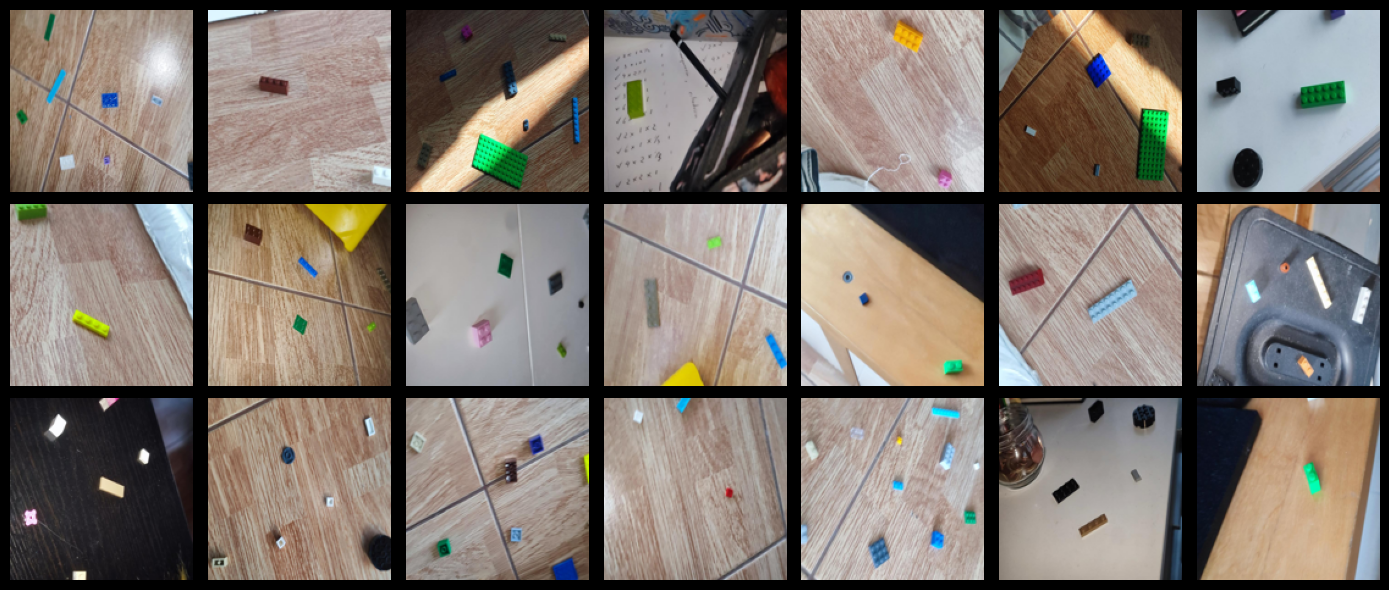

In [5]:
showcase_dataset_images(resized_spilt_bricks_raw_images_folder)

In [6]:
# given a folder of images, normalize the images names. ex: "image_0034.jpg"

def normalize_images_names(folder_path):
    for i, filename in enumerate(os.listdir(folder_path)):
        os.rename(folder_path + "\\" + filename, folder_path + "\\" + f"image_{str(i).zfill(4)}.jpg")

# normalize_images_names(spilt_bricks_raw_images_folder)

In [7]:
# Given an origin folder, an output folder, and a target size, resize all images in the origin folder to the target size and save them in the output folder.

def resize_images(origin_folder, output_folder, factor):
    """
    Resize all images in the origin folder by a given factor and save them in the output folder.

    Parameters:
    origin_folder (str): Path to the folder containing the original images.
    output_folder (str): Path to the folder where resized images will be saved.
    factor (float): Factor by which to resize images, e.g., 0.5 for half size, 2 for double size.

    Returns:
    None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(origin_folder):
        if filename.endswith(".jpg"):
            try:
                image_path = os.path.join(origin_folder, filename)
                with Image.open(image_path) as image:
                    new_size = (int(image.width * factor), int(image.height * factor))
                    resized_image = image.resize(new_size)
                    resized_image.save(os.path.join(output_folder, filename))
            except Exception as e:
                print(f"Error processing {filename}: {e}")

In [8]:
# the images sizes present in raw images folder

def get_image_sizes(folder):
    """
    Get the sizes of all images in a folder.

    Parameters:
    folder (str): Path to the folder containing the images.

    Returns:
    list: List of unique image sizes present in the folder.
    """
    sizes = set()
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            with Image.open(os.path.join(folder, filename)) as image:
                sizes.add(image.size)
    return list(sizes)

# get the image sizes of the raw images folder

# get_image_sizes(spilt_bricks_raw_images_folder)


In [9]:
# number of images in the raw images folder

def get_number_of_images(folder):
    """
    Get the number of images in a folder.

    Parameters:
    folder (str): Path to the folder containing the images.

    Returns:
    int: Number of images in the folder.
    """
    return len([filename for filename in os.listdir(folder) if filename.endswith(".jpg")])

get_number_of_images(spilt_bricks_raw_images_folder)

0

In [10]:
resize_factor = 800 / 4000 # 800 is the target size, 4000 is the original size, factor is 1/5

# resize the images in the raw images folder

# resize_images(spilt_bricks_raw_images_folder, resized_spilt_bricks_raw_images_folder, resize_factor)

In [11]:
# Labelme must be instll in the enviroment and executed from bash.

# !Labelme

During the annotation process blurred images remained un-touch. their lack of corresponding .json file can be used to remove them from the data in batch:

In [12]:

def remove_invalid_jpg_files(folder_path):
    """
    Remove .jpg files from the folder that are not in the list of valid files.

    Parameters:
    folder_path (str): Path to the folder containing the images and labelme files.

    Returns:
    None
    """
    # get the list of json labelme files

    labelme_files = [filename for filename in os.listdir(resized_spilt_bricks_raw_images_folder) if filename.endswith(".json")]

    # turn .json extension to .jpg

    jpg_valid_files = [filename.replace(".json", ".jpg") for filename in labelme_files]

    # delete jpg files that are not valid

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") and filename not in jpg_valid_files:
            os.remove(os.path.join(folder_path, filename))

# Example usage
# remove_invalid_jpg_files(resized_spilt_bricks_raw_images_folder)


# Model Selection

When selecting a model for this project, I needed one that could efficiently detect and classify Lego pieces within a cluttered image. My primary focus was on finding a solution that balanced accuracy with ease of use, while also requiring minimal setup time. This allowed me to focus more on data preparation and analysis rather than configuring a complex model. After considering several options, I chose YOLO (You Only Look Once), specifically version 8n, due to its straightforward setup, speed, and accuracy. YOLO's real-time detection capabilities and simple implementation made it ideal for identifying multiple Lego pieces within a single image, even when those pieces were scattered and partially occluded.

YOLO's architecture is particularly well-suited for object detection tasks where speed is crucial and the ability to work in real-world, cluttered environments is essential. Unlike other models that might require significant computational power or intricate pre-processing steps, YOLO is designed to be efficient and can perform detection in just one pass through the neural network. This made it an ideal choice for my hardware setup, which has limited GPU capabilities, while also allowing for rapid iteration during the development phase.

Using YOLO, I trained a model capable of reliably detecting individual bricks and tiles across various lighting conditions and backgrounds. Once trained, I developed a simple script to crop each detected Lego piece from the image. This cropping script was essential because it allowed me to isolate each piece for further analysis. Processing the pieces individually simplified the classification task and provided more control over the input data for subsequent steps. This approach laid a solid foundation for further classification and more detailed analysis, paving the way for distinguishing features such as dimensions, color, and brick type.



In [13]:
# given a folder with labelme json files, convert them to yolo format txt files
def labelme_jsons_to_yolos(folder):
    """
    Convert LabelMe JSON files to YOLO format text files.

    Parameters:
    folder (str): Path to the folder containing LabelMe JSON files.

    Returns:
    None
    """
    
    def get_image_size_from_json(json_file):
        """
        Extract image size from a LabelMe JSON file.

        Parameters:
        json_file (str): Path to the LabelMe JSON file.

        Returns:
        tuple: Image height and width.
        """
        with open(json_file, "r") as file:
            data = json.load(file)
        return data["imageHeight"], data["imageWidth"]
    
    def labelme_json_to_yolo(json_file, yolo_file, image_size):
        """
        Convert a single LabelMe JSON file to YOLO format.

        Parameters:
        json_file (str): Path to the LabelMe JSON file.
        yolo_file (str): Path to the output YOLO format text file.
        image_size (tuple): Image height and width.

        Returns:
        None
        """
        with open(json_file, "r") as file:
            data = json.load(file)

        with open(yolo_file, "w") as file:
            for shape in data["shapes"]:
                points = shape["points"]
                x1, y1 = points[0]
                x2, y2 = points[1]
                x1, y1, x2, y2 = x1 / image_size[1], y1 / image_size[0], x2 / image_size[1], y2 / image_size[0]
                x, y = (x1 + x2) / 2, (y1 + y2) / 2
                width, height = x2 - x1, y2 - y1
                file.write(f"0 {x} {y} {width} {height}\n")

    def fix_negative_values(labels_dir: str) -> None:
        """
        Fix negative values in YOLO annotations.

        Args:
            labels_dir (str): Path to the directory containing the YOLO label files.

        Returns:
            None
        """

        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

        for label_file in label_files:
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()

            with open(os.path.join(labels_dir, label_file), 'w') as f:
                for line in lines:
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    if width < 0:
                        width = abs(width)
                    if height < 0:
                        height = abs(height)
                    f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
    
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            json_file = os.path.join(folder, filename)
            yolo_file = os.path.join(folder, filename.replace(".json", ".txt"))
            image_size = get_image_size_from_json(json_file)
            labelme_json_to_yolo(json_file, yolo_file, image_size)

    fix_negative_values(folder)


In [14]:
# labelme_jsons_to_yolos(resized_spilt_bricks_raw_images_folder)

In [15]:
# Function to plot a grid of annotated images

def visualize_yolo_annotated_images(image_folder, annotation_folder, num_images=6, specific_files=[], class_names=["LegoBrick"]):
    """
    Visualize a given number of random images annotated with YOLO bounding boxes.

    Parameters:
    image_folder (str): Path to the folder containing images.
    annotation_folder (str): Path to the folder containing YOLO annotation files.
    num_images (int): Number of images to visualize. Default is 6.
    specific_files (list): List of specific image files to visualize. Default is empty list.
    class_names (list): List of class names corresponding to class IDs. Default is ["LegoBrick"].

    Returns:
    None
    """

    # Function to read YOLO annotations

    def read_yolo_annotation(annotation_path, image_width, image_height):
        """
        Read YOLO annotation file and convert normalized bounding box coordinates to pixel values.

        Parameters:
        annotation_path (str): Path to the YOLO annotation file.
        image_width (int): Width of the image.
        image_height (int): Height of the image.

        Returns:
        list: List of bounding boxes with pixel coordinates and class IDs.
        """
        boxes = []
        with open(annotation_path, 'r') as file:
            for line in file:
                # YOLO format: class_id, x_center, y_center, width, height (normalized)
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Convert normalized values to actual pixel values
                x_center *= image_width
                y_center *= image_height
                width *= image_width
                height *= image_height

                # Get coordinates for the bounding box
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)

                boxes.append((x_min, y_min, x_max, y_max, int(class_id)))
        return boxes

    # Get list of images and annotations
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    annotation_files = [f for f in os.listdir(annotation_folder) if f.endswith('.txt')]
    
    # Sort to match images and annotations correctly
    image_files.sort()
    annotation_files.sort()

    # Shuffle and select a random subset of images and annotations
    combined_files = list(zip(image_files, annotation_files))
    random.shuffle(combined_files)

    # If specific files are provided, filter to those files and add them on top
    if specific_files:
        specific_combined_files = [(img, ann) for img, ann in zip(image_files, annotation_files) if img in specific_files]
        combined_files = specific_combined_files + combined_files

    # Select the final subset of images and annotations
    combined_files = combined_files[:num_images]

    # Set up the plot grid
    num_images = min(num_images, len(combined_files))
    cols = 3
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.patch.set_facecolor('black')  # Set figure background to black
    axes = axes.flatten()

    # Loop through the selected number of images
    for i in range(num_images):
        image_file, annotation_file = combined_files[i]
        image_path = os.path.join(image_folder, image_file)
        annotation_path = os.path.join(annotation_folder, annotation_file)
        
        # Load image
        image = Image.open(image_path)
        image_cv = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        width, height = image.size

        # Read annotations
        boxes = read_yolo_annotation(annotation_path, width, height)

        # Draw bounding boxes
        for (x_min, y_min, x_max, y_max, class_id) in boxes:
            cv2.rectangle(image_cv, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_cv, str(class_names[class_id]), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Plot the image with annotations
        axes[i].imshow(image_cv)
        axes[i].set_title(image_file, color='yellow')
        axes[i].axis('off')
        axes[i].set_facecolor('black')

    # Hide any extra subplots
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



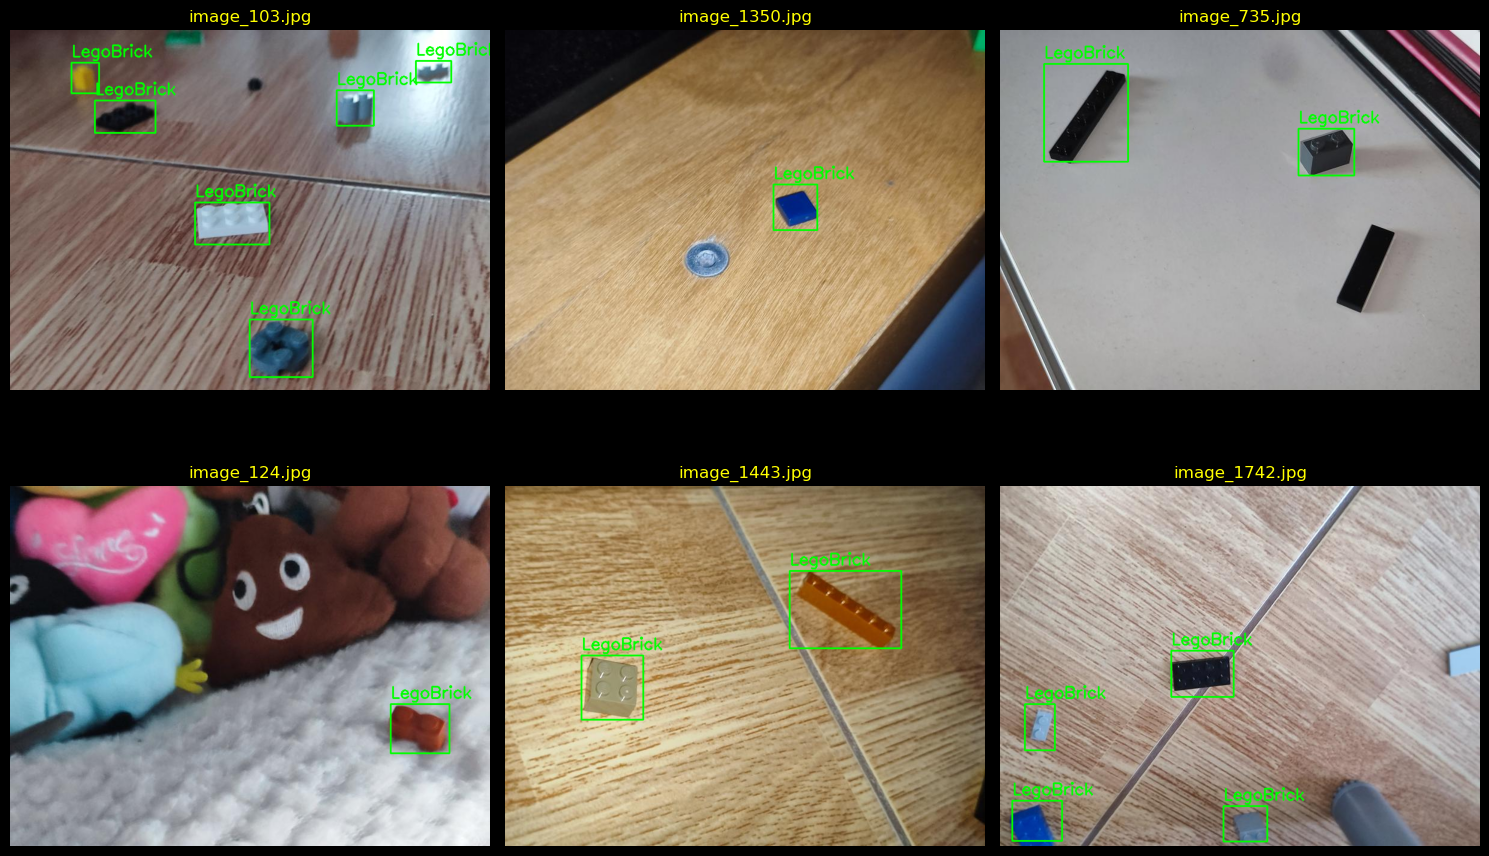

In [16]:
# Example usage
visualize_yolo_annotated_images(resized_spilt_bricks_raw_images_folder, resized_spilt_bricks_raw_images_folder, num_images=6, 
                                # specific_files=["image_0.jpg", "image_1.jpg"]
                                )

In [17]:
# a function to prepare a YOLO dataset structure 
# by listing all image and label files in the origin folder,
# creating the required YOLO training directory structure, 
# and performing an 80-20 train-val split. Also creates the dataset.yaml file required for YOLO training.

def prepare_yolo_dataset(origin_folder, output_folder, class_names = ['LegoBrick']):
    """
    Prepares a YOLO dataset structure by listing all image and label files in the origin folder,
    creating the required YOLO training directory structure, and performing an 80-20 train-val split.
    Also creates the dataset.yaml file required for YOLO training.

    Args:
        origin_folder (str): Path to the origin folder containing images and YOLO formatted label files.
        output_folder (str): Path to the output folder where YOLO dataset structure will be created.
        class_names (list): List of class names for the dataset. Default is ['stud'].
    """
    # List all image and label files in the origin folder
    image_files = [f for f in os.listdir(origin_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    label_files = [f for f in os.listdir(origin_folder) if f.endswith('.txt')]

    # Pair image files with their corresponding label files
    paired_files = []
    for image_file in image_files:
        label_file = os.path.splitext(image_file)[0] + '.txt'
        if label_file in label_files:
            paired_files.append((image_file, label_file))

    if len(paired_files) == 0:
        print("No matching image-label pairs found in the origin folder.")
        return

    # Create YOLO directory structure if it doesn't exist, or clear it if it does
    data_folder = os.path.join(output_folder, 'data')
    train_images_folder = os.path.join(data_folder, 'train', 'images')
    train_labels_folder = os.path.join(data_folder, 'train', 'labels')
    val_images_folder = os.path.join(data_folder, 'val', 'images')
    val_labels_folder = os.path.join(data_folder, 'val', 'labels')

    for folder in [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]:
        if os.path.exists(folder):
            shutil.rmtree(folder)  # Remove existing folder and its contents
        os.makedirs(folder)  # Create the required folder

    # Shuffle and split the files into train and validation sets (80-20 split)
    random.shuffle(paired_files)
    split_index = int(len(paired_files) * 0.8)
    train_files = paired_files[:split_index]
    val_files = paired_files[split_index:]

    # Copy the files to the appropriate train/val directories
    for image_file, label_file in train_files:
        shutil.copy(os.path.join(origin_folder, image_file), train_images_folder)
        shutil.copy(os.path.join(origin_folder, label_file), train_labels_folder)

    for image_file, label_file in val_files:
        shutil.copy(os.path.join(origin_folder, image_file), val_images_folder)
        shutil.copy(os.path.join(origin_folder, label_file), val_labels_folder)

    # Create or clean the dataset.yaml file /data/dataset.yaml"
    yaml_path = os.path.join(data_folder, 'dataset.yaml')
    if os.path.exists(yaml_path):
        os.remove(yaml_path)  # Remove the existing yaml file if it exists

    # Number of classes
    num_classes = len(class_names)

    # YAML dictionary structure
    dataset_yaml = {
        'train': os.path.join(data_folder, 'train', 'images'),
        'val': os.path.join(data_folder, 'val', 'images'),
        'nc': num_classes,
        'names': class_names
    }

    # Write YAML file
    with open(yaml_path, 'w') as file:
        yaml.dump(dataset_yaml, file, default_flow_style=False)

    # Summary report
    print("\nYOLO Dataset Preparation Summary:")
    print(f"- Training set: {len(train_files)} images and labels")
    print(f"- Validation set: {len(val_files)} images and labels")
    print(f"- Dataset YAML file created at: {yaml_path}")

    return yaml_path

In [18]:
# Example usage
origin_folder = resized_spilt_bricks_raw_images_folder  # Replace with the path to your origin folder
output_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\YOLO_finetune"  # Replace with the path to your output folder
yaml_brick_detectron_path = prepare_yolo_dataset(origin_folder, output_folder)  # Run the function to prepare the dataset



YOLO Dataset Preparation Summary:
- Training set: 1442 images and labels
- Validation set: 361 images and labels
- Dataset YAML file created at: C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\YOLO_finetune\data\dataset.yaml


In [19]:
def YOLO_oneLabel_train(YAML_file_path, Imgsz, label = "LegoBrick", epochs = 150, model = YOLO('yolov8n.pt')):

    # Train the model using the dataset.yaml file
    results = model.train(
        data= YAML_file_path,
        epochs=epochs,
        imgsz= Imgsz, # IMPORTANT, DOUBLE CHECK THE IMAGE SIZE
        batch=16,
        lr0=0.001,
        lrf=0.1,
        cos_lr=True,
        warmup_epochs=3,
        warmup_momentum=0.8,
        mosaic=0.5,
        auto_augment='randaugment',
        mixup=0.2,
        # a name that resembles the label, the base model and the moment of training
        name = f'YOLOdetectron_{label}_{model.model_name.split(".")[0]}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )

    # run model evaulation
    metrics = model.val()
    
    # save the model to the parent directory from the Yaml file folder

    parent_dir = Path(YAML_file_path).parent.parent

    model.save(parent_dir / f'YOLOdetectron_{label}_{model.model_name.split(".")[0]}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pt')

    return model



In [20]:

# Bricks_model = YOLO_oneLabel_train(yaml_brick_detectron_path, 800, "LegoBrick", 50)
Brick_model_path = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Models\YOLO_LegoBrick_Detectron_v0.pt"
Bricks_model = YOLO(Brick_model_path)

In [21]:
# given a image path and a model, run de predicction and plot the annotated image

def predict_and_plot(image_path, model, class_names=["LegoBrick"], conf_threshold=0.5):
    """
    Run prediction on a single image and plot the annotated image.

    Parameters:
    image_path (str): Path to the image file.
    model: YOLO model object.
    class_names (list): List of class names corresponding to class IDs. Default is ["LegoBrick"].
    """

    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for plotting

    # Get predictions from the model
    results = model.predict(source=image_path, save=False, show=False, imgsz=640, conf=conf_threshold)  # You can adjust the confidence threshold here

    # Extract predictions (bounding boxes and labels)
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    labels = results[0].boxes.cls.cpu().numpy()  # Class labels
    scores = results[0].boxes.conf.cpu().numpy()  # Confidence scores

    # Plot the image with annotations
    plt.figure(figsize=(10, 10)).patch.set_facecolor('black')
    plt.imshow(img_rgb)

    # Plot bounding boxes and labels
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='black', facecolor='none'))
        plt.text(x1, y1 - 10, f'{class_names[0]} | Conf: {score:.2f}', color='yellow', fontsize=12, backgroundcolor='black')

    plt.axis('off')
    #plot base color black
    
    plt.title(f'{os.path.basename(image_path)}', color='yellow')
    plt.show()


image 1/1 C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Raw_images\Resized\image_1696.jpg: 480x640 6 LegoBricks, 230.4ms
Speed: 11.0ms preprocess, 230.4ms inference, 18.0ms postprocess per image at shape (1, 3, 480, 640)


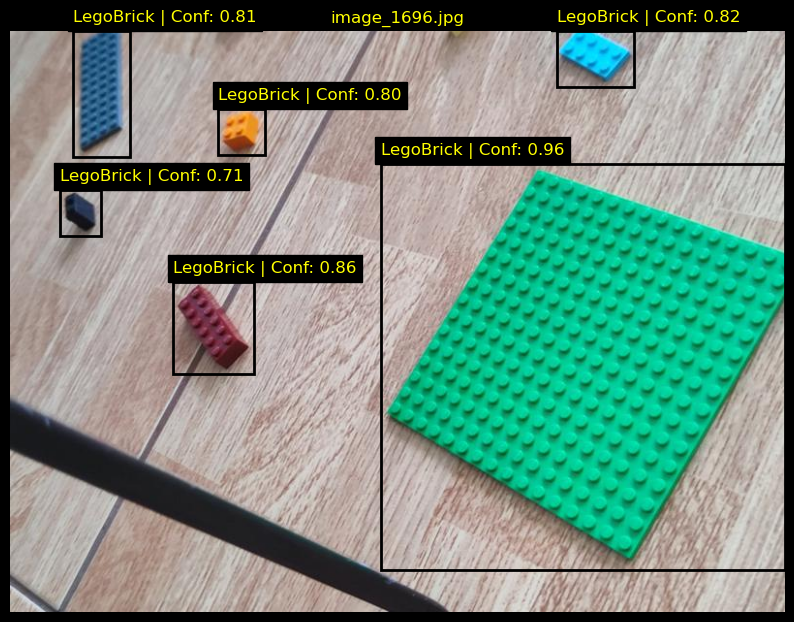

In [22]:
# predict and plot a random image in resized_spilt_bricks_raw_images_folder

image_files = [f for f in os.listdir(resized_spilt_bricks_raw_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)

predict_and_plot(os.path.join(resized_spilt_bricks_raw_images_folder, random_image), Bricks_model)

In [23]:
# given a origin folder,a an output folder, and a YOLO model. predict the bounding boxes of the images in the origin folder and save each box from each image in the output folder.
# naming for the new files {origon_file_name}_{box_identifier}_c{confidense_percentage_withoun_decimal_point}.jpg

def crop_bounding_boxes(origin_folder, output_folder, model, class_names=["LegoBrick"], conf_threshold=0.50):
    """
    Crop bounding boxes from images using a YOLO model and save them as separate images.

    Parameters:
    origin_folder (str): Path to the folder containing images.
    output_folder (str): Path to the folder where cropped images will be saved.
    model (YOLO): YOLO model object.
    class_names (list): List of class names corresponding to class IDs. Default is ["LegoBrick"].
    conf_threshold (float): Confidence threshold for object detection. Default is 0.50.

    Returns:    
    None
    """

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of image files
    image_files = [f for f in os.listdir(origin_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(origin_folder, image_file)
        image = Image.open(image_path)
        image_cv = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        width, height = image.size

        # Perform inference
        results = model(image_path, conf=conf_threshold)

        # Get bounding boxes and class IDs
        boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        labels = results[0].boxes.cls.cpu().numpy()  # Class labels
        scores = results[0].boxes.conf.cpu().numpy()  # Confidence scores

        # save cropped images

        for i, (box, score) in enumerate(zip(boxes, scores)):
            x_min, y_min, x_max, y_max = box
            class_name = class_names[0]
            conf_percentage = int(score * 100)
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            cropped_image.save(os.path.join(output_folder, f"{image_file.split(".")[0]}_{class_name}_{i}_c{conf_percentage}.jpg"))

        # for i, (box, class_id) in enumerate(zip(boxes, class_ids)):
        #     x_min, y_min, x_max, y_max, conf = box
        #     class_name = class_names[int(class_id)]
        #     conf_percentage = int(conf * 100)
        #     cropped_image = image.crop((x_min, y_min, x_max, y_max))
        #     cropped_image.save(os.path.join(output_folder, f"{image_file}_{class_name}_{i}_c{conf_percentage}.jpg"))



In [ ]:
cropped_bricks_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Cropped_bricks"
# test_path = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Raw_images\Resized\test"

crop_bounding_boxes(resized_spilt_bricks_raw_images_folder, cropped_bricks_folder, Bricks_model, class_names=["LegoBrick"], conf_threshold=0.50)
# crop_bounding_boxes(test_path, cropped_bricks_folder, Bricks_model, class_names=["LegoBrick"], conf_threshold=0.50)

# takes 6 minutes to run

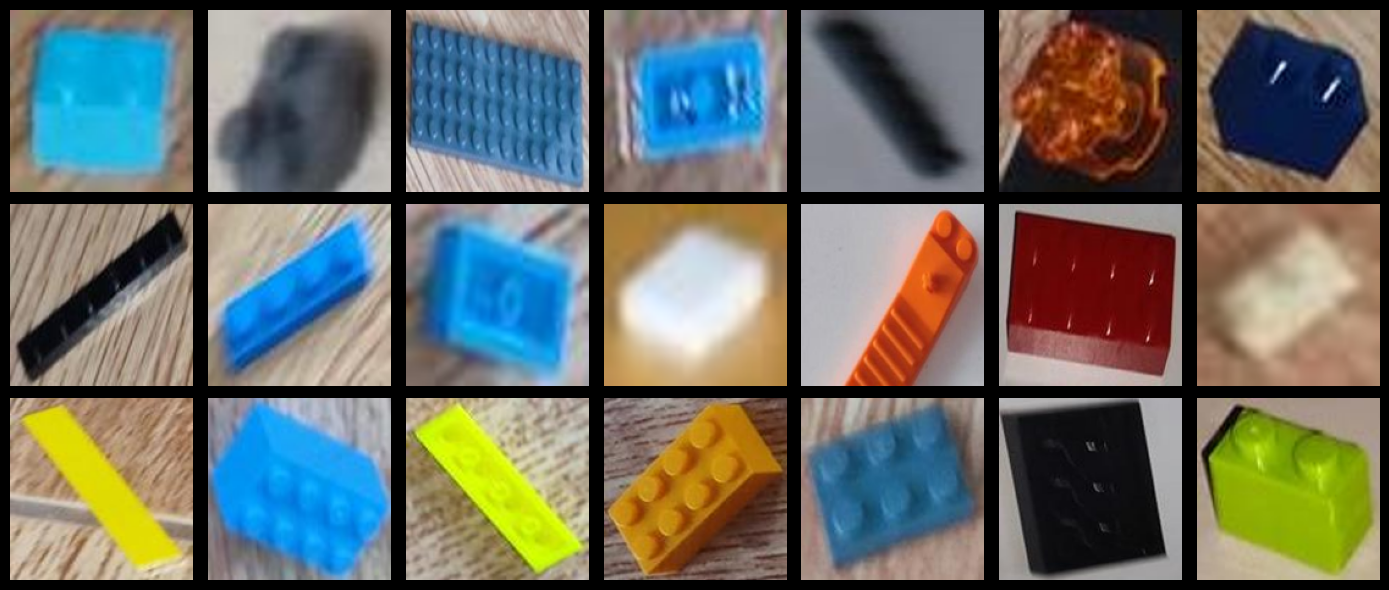

In [25]:
showcase_dataset_images(cropped_bricks_folder)

# Second Data Collection

After successfully detecting Lego pieces in cluttered images, I needed a more refined dataset to classify each piece by its unique dimensions accurately. This required a systematic approach to data collection and gave me an opportunity to solve problems creatively.

I built a setup using a spinning base to capture each Lego piece from multiple angles. The goal was to create a structured dataset where each brick could be thoroughly analyzed. The spinning base enabled consistent 360-degree views of each piece, ensuring comprehensive coverage for all classes. This approach allowed me to gather detailed images essential for building a more robust classification model.
The cropping script I previously developed was highly valuable during this phase. Using YOLO, I detected the Lego pieces in the images, and the cropping script allowed me to isolate each piece effectively. Working in batches made it easy to organize the cropped pieces by class, making the dataset more manageable and efficient.

I also applied my creativity during this stage by improvising a homemade setup with accessible materials. Using a rotating platform, consistent lighting, and a fixed camera position ensured high-quality, standardized captures. This combination of creative setup and automated tools highlighted my ability to innovate while staying resourceful, reinforcing my practical skills in data collection and preprocessing.



# Failed Classification Attempts

After completing the initial detection and cropping stages, I moved on to the classification task. The goal was to classify each Lego piece based on its unique dimensions and features. However, my early attempts at classification met with limited success due to several challenges inherent in the dataset.

First, although the dataset I created was diverse, it was ultimately too small to support accurate classification across all 26 classes. Some classes were significantly underrepresented, making it difficult for the model to learn effectively. This imbalance led to overfitting for certain classes, while the model struggled to generalize to others.

Additionally, the level of fine detail required to differentiate between certain Lego pieces posed a significant challenge. Many pieces had subtle differences in dimensions and features that were not sufficiently captured by the available data. The fine-grained nature of the classification required a level of representation that my dataset simply could not provide.

Ultimately, the combination of a small dataset, class imbalance, and insufficient feature detail led to the failure of the classification task. This experience underscored the importance of having a well-balanced dataset and ensuring that all classes are adequately represented, especially when dealing with subtle, fine-grained differences. Despite the challenges, this experience provided valuable insights into the difficulties of image-based classification and highlighted the limitations of my initial approach, which will inform future iterations of the project.



# Adaptation: Stud Detection for Dimensional Classification

After encountering challenges with the initial classification attempts, I decided to adapt my approach to determine the dimensions of each Lego piece. Instead of attempting to classify the entire piece directly, I focused on a key defining feature: the studs on top of each Lego brick. By training a model to detect these studs, I could use their coordinates to algorithmically determine the dimensions of each piece.

To achieve this, I used YOLO once again, as it had already proven effective for object detection earlier in the project. I annotated bounding boxes specifically around the studs on top of the Lego pieces, creating a new set of labeled images for training. The goal was to leverage the detected stud coordinates to infer important characteristics, such as the number of studs, which directly correlated with the dimensions of the brick.

With this adapted approach, YOLO was trained to detect studs reliably, and the resulting coordinates were used in an algorithmic process to classify the pieces based on their dimensions. By narrowing the focus to a specific feature of each piece, I simplified the classification task and achieved a more accurate estimation of the brick dimensions. This adaptation not only made the process more efficient but also underscored the importance of breaking down complex problems into smaller, more manageable components.




In [26]:
# !labelme

In [27]:
def convert_points_to_bounding_boxes(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all JSON files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.json'):
            json_path = os.path.join(input_folder, file_name)

            # Load the JSON file
            with open(json_path, 'r') as f:
                data = json.load(f)

            # Load corresponding image to get dimensions
            image_path = os.path.join(input_folder, data["imagePath"])
            with Image.open(image_path) as img:
                image_width, image_height = img.size
                image_area = image_width * image_height

            # Calculate the total area for the bounding boxes (1/5 of the image area)
            total_box_area = image_area / 5

            # Count the number of points in the JSON file
            points = [shape for shape in data['shapes'] if shape['shape_type'] == 'point']
            num_points = len(points)

            if num_points == 0:
                continue

            # Calculate the area for each box and determine the side length (boxes are squares)
            box_area = total_box_area / num_points
            box_side_length = math.sqrt(box_area)

            # Create bounding boxes centered around each point
            new_shapes = []
            for point in points:
                x, y = point['points'][0]
                half_side = box_side_length / 2

                # Calculate the coordinates of the bounding box
                x_min = max(0, x - half_side)
                y_min = max(0, y - half_side)
                x_max = min(image_width, x + half_side)
                y_max = min(image_height, y + half_side)

                # Create a new shape entry for the bounding box
                new_shape = {
                    "label": point["label"],
                    "points": [[x_min, y_min], [x_max, y_max]],
                    "group_id": point["group_id"],
                    "description": point["description"],
                    "shape_type": "rectangle",
                    "flags": point["flags"]
                }
                new_shapes.append(new_shape)

            # Replace the old shapes with the new bounding boxes
            data['shapes'] = new_shapes

            # Save the modified JSON to the output folder
            output_path = os.path.join(output_folder, file_name)
            with open(output_path, 'w') as f:
                json.dump(data, f, indent=4)

            #copy the corresponding image to the output folder
            shutil.copy(image_path, output_folder)

            

# Example usage
input_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Cropped_bricks"  # Replace with the path to your input folder
output_folder = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Cropped_with_boxes_test"  # Replace with the path to your output folder
convert_points_to_bounding_boxes(input_folder, output_folder)

In [28]:
labelme_jsons_to_yolos(output_folder)

In [29]:
def create_missing_txt_files(folder_path):
    """
    This function iterates through all .jpg files in a given folder and checks if there is a corresponding .txt file.
    If no such .txt file exists, it creates an empty .txt file. This is useful when preparing datasets for training
    object detection models like YOLO, where each image must have a paired annotation file.

    Including images with empty .txt files during YOLO training indicates that these images do not contain any
    objects of interest, helping the model learn background patterns and reducing false positives.

    Args:
        folder_path (str): The path to the folder containing .jpg images.
    """
    # Iterate over all .jpg files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):
            # Construct the expected .txt file name
            txt_file_name = file_name.replace('.jpg', '.txt')
            txt_file_path = os.path.join(folder_path, txt_file_name)

            # Check if the .txt file exists, if not create an empty one
            if not os.path.exists(txt_file_path):
                with open(txt_file_path, 'w') as f:
                    pass  # Create an empty .txt file

In [30]:
create_missing_txt_files(output_folder)

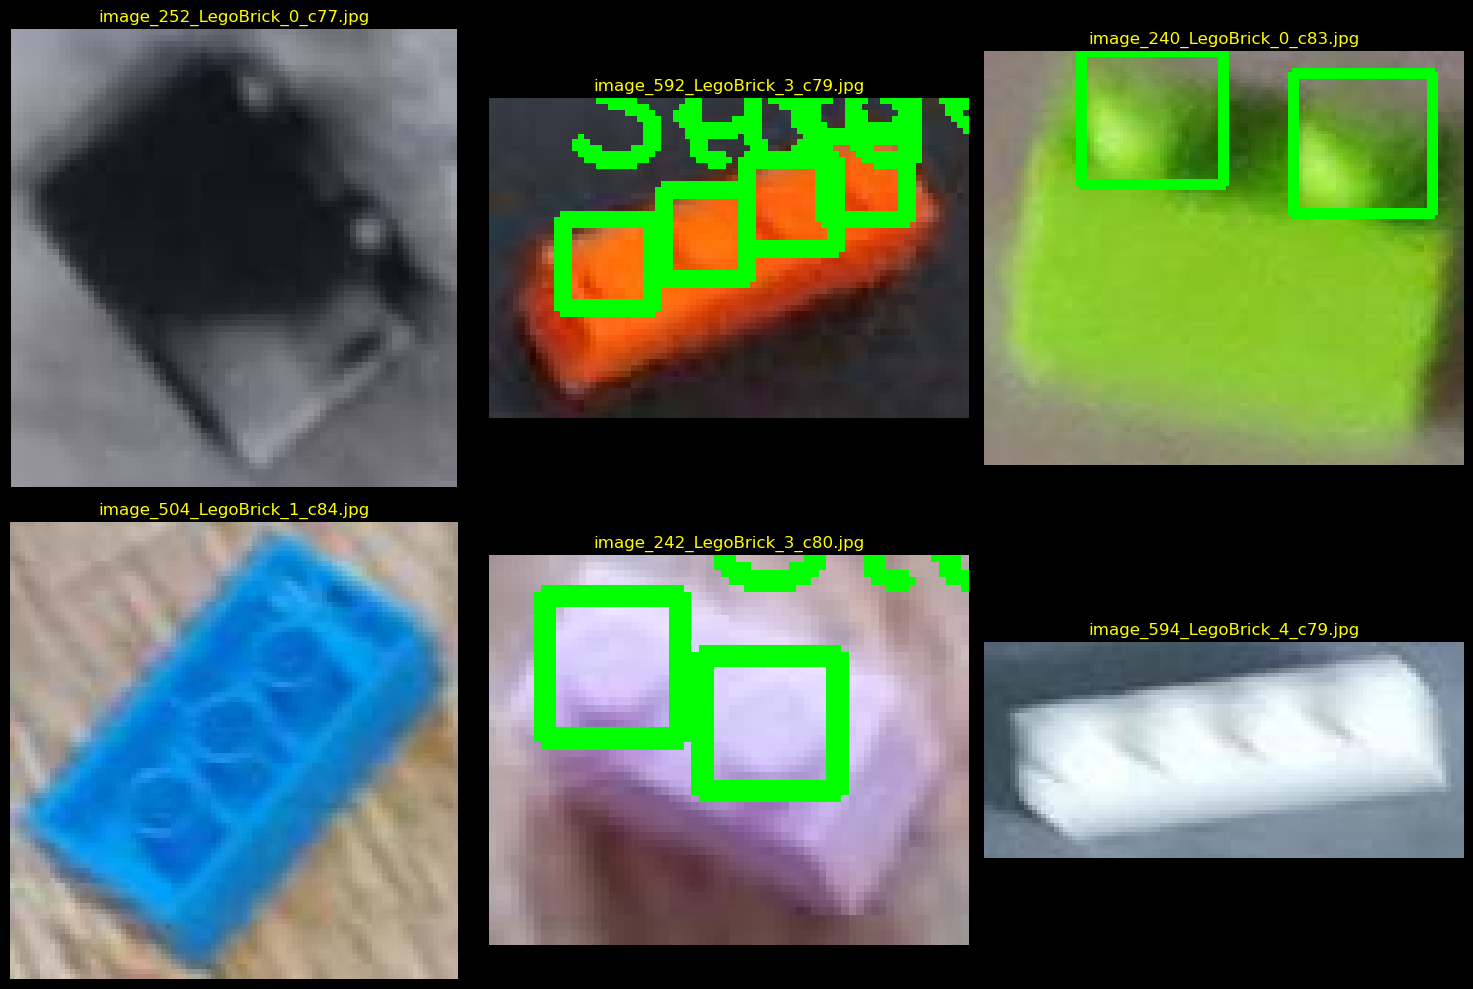

In [31]:
visualize_yolo_annotated_images(output_folder, output_folder, num_images=6, class_names=["Stud"])

In [32]:
Stud_Yolo_data_path = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\YOLO_studs"

yaml_stud_detectron_path = prepare_yolo_dataset(output_folder, Stud_Yolo_data_path, class_names=["Stud"])


YOLO Dataset Preparation Summary:
- Training set: 1740 images and labels
- Validation set: 436 images and labels
- Dataset YAML file created at: C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\YOLO_studs\data\dataset.yaml


In [33]:
# givena  folder. return a dataframe with the images paths, images heights, images widths, and the number of bounding boxes in the image.

def get_image_info(folder_path):

    # Create an empty list to store image information
    image_info = []

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            width, height = image.size

            # Count the number of bounding boxes in the corresponding .txt file
            txt_file_name = file_name.replace('.jpg', '.txt')
            txt_file_path = os.path.join(folder_path, txt_file_name)
            num_boxes = 0
            if os.path.exists(txt_file_path):
                with open(txt_file_path, 'r') as f:
                    num_boxes = len(f.readlines())

            # Append the image information to the list
            image_info.append({
                'image_path': image_path,
                'width': width,
                'height': height,
                'num_boxes': num_boxes
            })

    # Create a DataFrame from the list of image information
    df = pd.DataFrame(image_info)

    return df

In [34]:
image_data = get_image_info(output_folder)

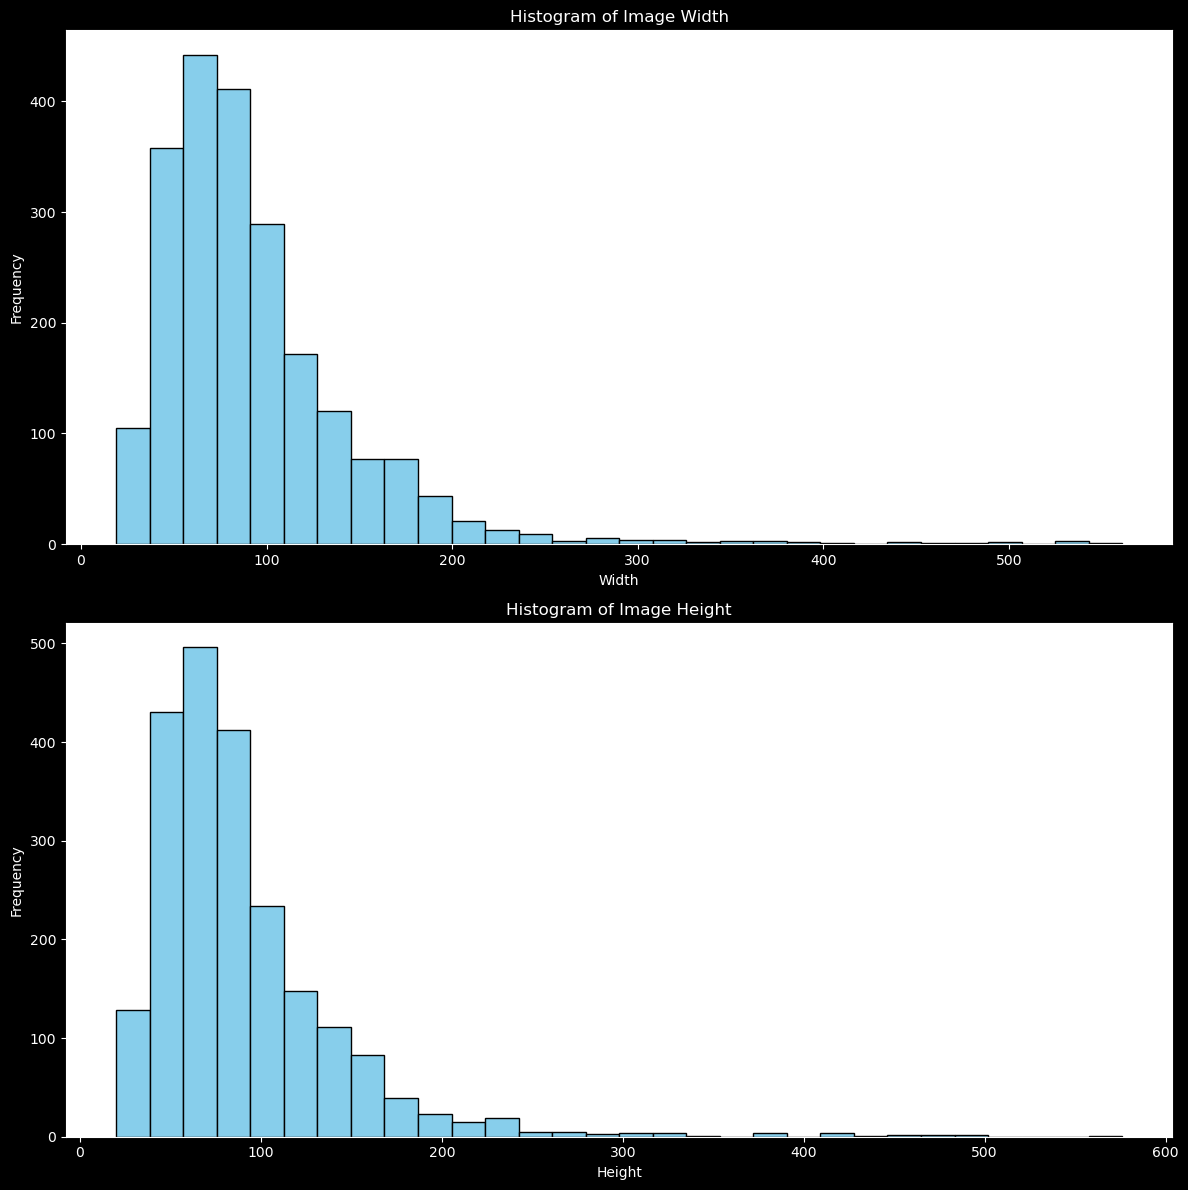

In [35]:
# using image_data plot a histogram  of the number of images againts their width and height

def plot_image_info_histograms(image_data):

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), facecolor='black')

    # Plot histograms for image width, height, and number of bounding boxes
    for i, col in enumerate(['width', 'height']):
        ax = axes[i]  # Corrected indexing
        ax.hist(image_data[col], bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'Histogram of Image {col.capitalize()}', color='white')
        ax.set_xlabel(col.capitalize(), color='white')
        ax.set_ylabel('Frequency', color='white')
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


plot_image_info_histograms(image_data)

In [36]:
# Stud_detectron_model = YOLO_oneLabel_train(yaml_stud_detectron_path, Imgsz = 128, label = "Stud", epochs = 150)
Stud_detectron_model_path = r"C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Models\YOLOdetectron_Stud_yolov8n_20241030_151507.pt"
Stud_detectron_model = YOLO(Stud_detectron_model_path)

In [37]:
output_folder

'C:\\Users\\User\\Desktop\\Final_Streamlit_Portfolio_Projects\\Brick_detectron_folder\\Cropped_with_boxes_test'


image 1/1 C:\Users\User\Desktop\Final_Streamlit_Portfolio_Projects\Brick_detectron_folder\Cropped_with_boxes_test\image_623_LegoBrick_4_c76.jpg: 640x576 2 LegoBricks, 122.3ms
Speed: 5.0ms preprocess, 122.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


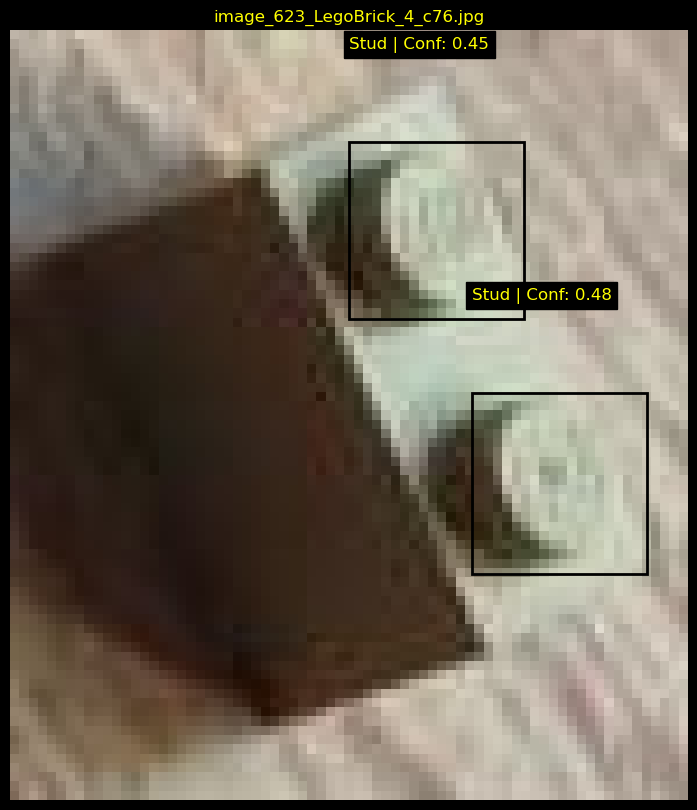

In [38]:
image_files = [f for f in os.listdir(output_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)

predict_and_plot(os.path.join(output_folder, random_image), Stud_detectron_model, class_names=["Stud"], conf_threshold=0.20)

# Conclusions, Reflections, and Lessons Learned

Reflecting on this project, I encountered numerous challenges, adaptations, and valuable lessons in tackling Lego piece detection and classification. Each phase—from data collection to model training and refining my approach—provided insights into both the technical aspects and the problem-solving mindset crucial for success in machine learning.

One key lesson was the importance of a high-quality dataset. Early classification attempts faltered due to a small dataset size, class imbalance, and insufficient feature representation. This experience underscored how vital data quality is for model performance and showed that investing time in preparing balanced, comprehensive data can save significant effort during later stages.

Adaptability proved essential. When the initial model struggled, I adapted by breaking the problem down and focusing on a simpler feature—the studs on each brick—which made the task more manageable. This highlighted that simplifying complex problems and iterating after setbacks often results in effective learning and solutions.

The project also demonstrated the strengths and limitations of different machine learning tools. YOLO was highly efficient for object detection but had limitations when it came to fine-grained classification. Understanding the appropriate context for each model's use is a critical skill, and this project helped me refine that understanding.

In conclusion, this project taught me valuable technical skills in computer vision, dataset preparation, and model adaptation, while also deepening my appreciation for the iterative nature of machine learning. Facing and overcoming challenges through creative problem-solving leads to growth, and I am excited to carry these lessons into future projects.
